In [1]:
from transformers import BertTokenizer
from transformers import BertTokenizerFast
from datasets import Dataset, DatasetDict, load_from_disk
from transformers import BertForMaskedLM

c:\Users\matej\SKOLA\Diplomovka\Code\EmbeddingModels\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [78]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [79]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

In [91]:
dataset = load_from_disk("MLM_fake_generalization_data_with_article_ids_256")

# Path to your saved checkpoint directory
checkpoint_path = "./training_prog_256_final1/results/checkpoint-198940"

# Load the model from the checkpoint
model = BertForMaskedLM.from_pretrained(checkpoint_path)

In [92]:
model.to(device)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(256, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [93]:
print(next(model.parameters()).device)

cuda:0


In [94]:
dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'article_id', 'label'],
    num_rows: 27791
})

In [82]:
dataset = dataset.remove_columns("word_ids")

In [95]:
from collections import defaultdict


def group_chunks(dataset):
    grouped_chunks = defaultdict(lambda: {"data": [], "label": None})

    # Group chunks by article_id and add article_id and label to the group
    for chunk in dataset:
        article_id = chunk["article_id"]
        label = chunk["label"]

        # Create a new chunk without 'article_id' and 'label'
        chunk_data = {
            k: v for k, v in chunk.items() if k not in ["article_id", "label"]
        }

        # Append the chunk data to the correct article group
        grouped_chunks[article_id]["data"].append(chunk_data)
        grouped_chunks[article_id][
            "label"
        ] = label  # Since label is the same for all chunks in an article

    # Convert the defaultdict to a list of formatted dictionaries
    return [
        {"data": group["data"], "article_id": article_id, "label": group["label"]}
        for article_id, group in grouped_chunks.items()
    ]

In [96]:
grouped_chunks = group_chunks(dataset)

In [9]:
len(grouped_chunks)

5990

In [2]:
import torch.nn.functional as F
import copy

In [51]:
from transformers import DataCollatorForLanguageModeling
import numpy as np

# Define the data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,  # Use the tokenizer you trained with
    mlm=True,  # Enable masking
    mlm_probability=0.15,  # 15% of tokens will be masked (BERT default)
)

In [52]:
def get_cosine_similarities(dataset, model, tokenizer):
    cos_similarities = []

    for row in dataset:

        row_masked = [copy.deepcopy(row)]
        row_masked = data_collator(row_masked)

        tensor_row = {key: torch.tensor([row[key]]) for key in row}

        row_masked = {key: value.to(device) for key, value in row_masked.items()}

        tensor_row = {key: value.to(device) for key, value in tensor_row.items()}

        with torch.no_grad():

            output_masked = model(**row_masked, output_hidden_states=True)
            output_nonmasked = model(**tensor_row, output_hidden_states=True)

        masked_positions = (row_masked["labels"] != -100).nonzero(as_tuple=True)[1]

        hidden_states_masked = output_masked.hidden_states[-1]
        masked_embeddings = hidden_states_masked[0, masked_positions, :]

        # get embedding from last hidden layer for real words on masked positions
        hidden_states_nonmasked = output_nonmasked.hidden_states[-1]
        actual_embeddings = hidden_states_nonmasked[0, masked_positions, :]

        cosine_similarities = []

        for masked_emb, actual_emb in zip(masked_embeddings, actual_embeddings):

            similarity = F.cosine_similarity(
                masked_emb.unsqueeze(0), actual_emb.unsqueeze(0)
            )
            cosine_similarities.append(similarity.item())
        cos_similarities.append(cosine_similarities)

    return cos_similarities

In [53]:
def get_similarities_for_articles(data, model, tokenizer):
    similarities = {}
    for article in data:
        chunks = article["data"]
        article_id = article["article_id"]
        label = article["label"]
        article_similarities = get_cosine_similarities(chunks, model, tokenizer)

        similarities[article_id] = {
            "label": label,
            "article_similarities": article_similarities,
        }

    return similarities

In [54]:
all_similarities = get_similarities_for_articles(grouped_chunks, model, tokenizer)

In [55]:
import pickle


# Save defaultdict to a file
def save_defaultdict(data, filename):
    with open(filename, "wb") as f:
        pickle.dump(data, f)


save_defaultdict(all_similarities, "cosine_similarities_generalization_128.pkl")

In [ ]:
import pickle


# Load defaultdict from a pickle file
def load_defaultdict(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data


all_similarities = load_defaultdict("cosine_similarities_generalization_256.pkl")

In [76]:
all_similarities[0]

{'label': 0,
 'article_similarities': [[0.9910404086112976,
   0.8330944180488586,
   0.7644830346107483,
   0.9763064384460449,
   0.82860267162323,
   0.6316606998443604,
   0.6668955683708191,
   0.6947353482246399,
   0.7502620220184326,
   0.41321948170661926,
   0.8217844367027283,
   0.8146418929100037,
   0.4598400890827179,
   0.9945367574691772,
   0.9917094707489014,
   0.6549168229103088,
   0.9742869138717651,
   0.7724089026451111,
   0.6398820877075195,
   0.6170458793640137,
   0.6770745515823364,
   0.7195927500724792,
   0.795966386795044,
   0.6982587575912476,
   0.5656644105911255,
   0.5546984076499939,
   0.8845198154449463,
   0.7024232149124146,
   0.8270209431648254,
   0.6069740056991577,
   0.6210905313491821,
   0.8280870914459229,
   0.8658665418624878,
   0.7971113920211792,
   0.5972217321395874,
   0.7452385425567627,
   0.5706127882003784,
   0.9907678365707397,
   0.7131085991859436,
   0.9142731428146362,
   0.9754266738891602,
   0.6002132296562195,

In [ ]:
import pandas as pd
import numpy as np


def create_similarity_dataframe(grouped_chunks):
    data = []

    for article_id, values in grouped_chunks.items():

        label = values["label"]
        article_similarities = values["article_similarities"]

        flat_list = [item for sublist in article_similarities for item in sublist]
        avg_similarity = np.mean(flat_list)

        data.append(
            {"article_id": article_id, "label": label, "avg_similarity": avg_similarity}
        )

    df = pd.DataFrame(data)
    return df

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
all_similarities_256 = load_defaultdict("cosine_similarities_generalization_256.pkl")
all_similarities_128 = load_defaultdict("cosine_similarities_generalization_128.pkl")

In [7]:
df_similarities_128 = create_similarity_dataframe(all_similarities_128)
df_similarities_256 = create_similarity_dataframe(all_similarities_256)

c:\Users\matej\SKOLA\Diplomovka\Code\EmbeddingModels\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\matej\SKOLA\Diplomovka\Code\EmbeddingModels\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
df_similarities_128 = df_similarities_128.dropna()
df_similarities_256 = df_similarities_256.dropna()

In [9]:
df_label_0_128 = df_similarities_128[df_similarities_128["label"] == 0]
df_label_1_128 = df_similarities_128[df_similarities_128["label"] == 1]
df_label_0_256 = df_similarities_256[df_similarities_256["label"] == 0]
df_label_1_256 = df_similarities_256[df_similarities_256["label"] == 1]

In [14]:
df_label_0_128["avg_similarity"].median()

0.7035767859346671

In [15]:
df_label_1_128["avg_similarity"].median()

0.7007104530427102

In [16]:
df_label_0_256["avg_similarity"].median()

0.6773406956389726

In [17]:
df_label_1_256["avg_similarity"].median()

0.6684553724136378

In [19]:
df_label_1_128.describe()

,article_id,label,avg_similarity
count,2951.000000,2951.0,2951.000000
mean,3000.886479,1.0,0.701725
std,1711.106708,0.0,0.022823
min,2.000000,1.0,0.551007
25%,1534.500000,1.0,0.688701
50%,3032.000000,1.0,0.700710
75%,4465.000000,1.0,0.713592
max,5989.000000,1.0,0.838991


C:\Users\matej\AppData\Local\Temp\ipykernel_23888\3401751642.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


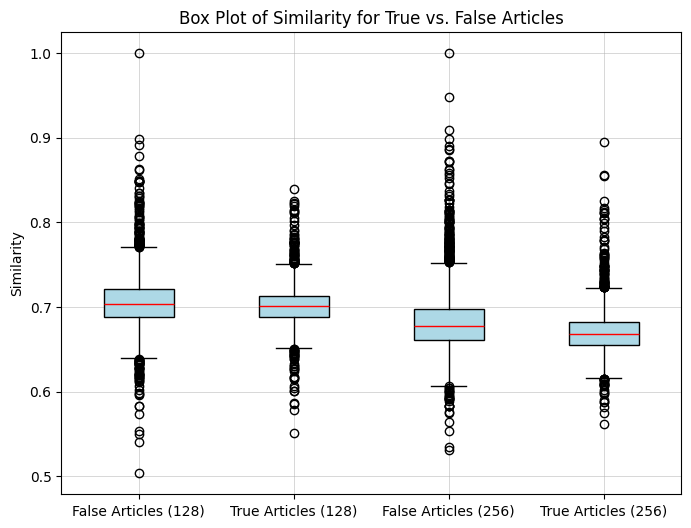

In [122]:
# Combine into a list for plotting
data = [
    df_label_0_128["avg_similarity"],
    df_label_1_128["avg_similarity"],
    df_label_0_256["avg_similarity"],
    df_label_1_256["avg_similarity"],
]
labels = [
    "False Articles (128)",
    "True Articles (128)",
    "False Articles (256)",
    "True Articles (256)",
]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),  # Color for boxes
    medianprops=dict(color="red"),
)  # Color for median lines

plt.grid(True, linewidth=0.5, alpha=0.7)

# Add title and labels
plt.title("Box Plot of Similarity for True vs. False Articles")
plt.ylabel("Similarity")

# Show the plot
plt.savefig("boxplot_similarity.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

In [118]:
def calculate_outliers(data):
    # Calculate Q1, Q3, and IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(lower_bound)
    print(upper_bound)
    # Identify outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers


# Calculate outliers for each class
true_articles_outliers = calculate_outliers(df_label_1_128["avg_similarity"])
false_articles_outliers = calculate_outliers(df_label_0_128["avg_similarity"])

# Print the number of outliers
print(f"Number of outliers in True Articles: {len(true_articles_outliers)}")
print(f"Number of outliers in False Articles: {len(false_articles_outliers)}")

0.6513646188500007
0.7509280151945515
0.6390595062371238
0.7712759395950504
Number of outliers in True Articles: 103
Number of outliers in False Articles: 150


In [119]:
# Calculate outliers for each class
true_articles_outliers = calculate_outliers(df_label_1_256["avg_similarity"])
false_articles_outliers = calculate_outliers(df_label_0_256["avg_similarity"])

# Print the number of outliers
print(f"Number of outliers in True Articles: {len(true_articles_outliers)}")
print(f"Number of outliers in False Articles: {len(false_articles_outliers)}")

0.615420368954452
0.7221925011497177
0.6067628334645631
0.7525813378414147
Number of outliers in True Articles: 100
Number of outliers in False Articles: 174


In [77]:
df_similarities = create_similarity_dataframe(all_similarities)

c:\Users\matej\SKOLA\Diplomovka\Code\EmbeddingModels\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\matej\SKOLA\Diplomovka\Code\EmbeddingModels\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [78]:
df_similarities

,article_id,label,avg_similarity
0,0,0,0.721050
1,1,0,0.700592
2,2,1,0.653640
3,3,0,0.687255
4,4,1,0.653405
...,...,...,...
5985,5985,1,0.689091
5986,5986,0,0.662255
5987,5987,0,0.674059
5988,5988,1,0.654285


In [79]:
df_similarities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5990 entries, 0 to 5989
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   article_id      5990 non-null   int64  
 1   label           5990 non-null   int64  
 2   avg_similarity  5986 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 140.5 KB


In [80]:
df_similarities = df_similarities.dropna()

In [81]:
df_similarities.describe()

,article_id,label,avg_similarity
count,5986.000000,5986.000000,5986.000000
mean,2994.503675,0.492984,0.676666
std,1729.713931,0.499993,0.032685
min,0.000000,0.000000,0.531321
25%,1496.250000,0.000000,0.658236
50%,2994.500000,0.000000,0.672335
75%,4492.750000,1.000000,0.688832
max,5989.000000,1.000000,1.000000


In [82]:
df_label_0 = df_similarities[df_similarities["label"] == 0]
df_label_1 = df_similarities[df_similarities["label"] == 1]

In [83]:
df_label_0 = df_label_0.reset_index()
df_label_1 = df_label_1.reset_index()

In [84]:
df_label_0.describe()

,index,article_id,label,avg_similarity
count,3035.000000,3035.000000,3035.0,3035.000000
mean,2988.389127,2988.389127,0.0,0.683003
std,1747.793940,1747.793940,0.0,0.037715
min,0.000000,0.000000,0.0,0.531321
25%,1472.000000,1472.000000,0.0,0.661445
50%,2955.000000,2955.000000,0.0,0.677341
75%,4525.500000,4525.500000,0.0,0.697899
max,5987.000000,5987.000000,0.0,1.000000


In [85]:
df_label_1.describe()

,index,article_id,label,avg_similarity
count,2951.000000,2951.000000,2951.0,2951.000000
mean,3000.792274,3000.792274,1.0,0.670148
std,1711.193383,1711.193383,0.0,0.024914
min,2.000000,2.000000,1.0,0.562047
25%,1532.000000,1532.000000,1.0,0.655460
50%,3032.000000,3032.000000,1.0,0.668455
75%,4465.000000,4465.000000,1.0,0.682153
max,5989.000000,5989.000000,1.0,0.894841


In [ ]:
from sklearn.metrics import accuracy_score

min_threshold = df_similarities["avg_similarity"].min()
max_threshold = df_similarities["avg_similarity"].max()
thresholds = np.linspace(min_threshold, max_threshold, 1000)

best_threshold = None
best_score = -1
best_predictions = None

for threshold in thresholds:

    predictions = (df_similarities["avg_similarity"] >= threshold).astype(int)

    score = accuracy_score(df_similarities["label"], predictions)

    if score > best_score:
        best_score = score
        best_threshold = threshold
        best_predictions = predictions

print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy: {best_score}")

Best Threshold: 0.9488628089928814
Best Accuracy: 0.5068493150684932


In [87]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

class_report = classification_report(df_similarities["label"], best_predictions)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(df_similarities["label"], best_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      3035
           1       0.00      0.00      0.00      2951

    accuracy                           0.51      5986
   macro avg       0.25      0.50      0.34      5986
weighted avg       0.26      0.51      0.34      5986

Confusion Matrix:
[[3034    1]
 [2951    0]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_true = df_similarities["label"]
y_pred = best_predictions

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Accuracy: 0.507


# Word accuracy


In [85]:
import numpy as np

In [ ]:
from transformers import DataCollatorForLanguageModeling
import numpy as np

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
)

In [ ]:
def get_accuracies(dataset, model, tokenizer):
    accuracies = []
    for row in dataset:
        row_masked = [copy.deepcopy(row)]
        row_masked = data_collator(row_masked)
        row_masked = {key: value.to(device) for key, value in row_masked.items()}

        with torch.no_grad():
            output_masked = model(**row_masked, output_hidden_states=True)

        logits = output_masked.logits
        masked_positions = (row_masked["labels"] != -100).nonzero(as_tuple=True)[1]
        predicted_tokens = torch.argmax(logits[0, masked_positions], dim=-1)

        labels = row_masked["labels"]
        actual_tokens = labels[0, masked_positions]

        predicted_words = [
            tokenizer.decode([token_id], skip_special_tokens=True)
            for token_id in predicted_tokens
        ]

        actual_words = [
            tokenizer.decode([token_id], skip_special_tokens=True)
            for token_id in actual_tokens
        ]

        accuracy_array = np.zeros(len(predicted_words), dtype=int)

        for i in range(len(predicted_words)):
            if predicted_words[i] == actual_words[i]:
                accuracy_array[i] = 1
            else:
                accuracy_array[i] = 0

        accuracies.append(accuracy_array)

    return accuracies

In [99]:
import copy


def get_accuracies_for_articles(data, model, tokenizer):

    accuracies = {}

    for article in data:

        chunks = article["data"]

        article_id = article["article_id"]

        label = article["label"]

        article_accuracies = get_accuracies(chunks, model, tokenizer)

        accuracies[article_id] = {
            "label": label,
            "article_similarities": article_accuracies,
        }

    return accuracies

In [100]:
all_accuracies = get_accuracies_for_articles(grouped_chunks, model, tokenizer)

In [102]:
import pickle


# Save defaultdict to a file
def save_defaultdict(data, filename):
    with open(filename, "wb") as f:
        pickle.dump(data, f)


save_defaultdict(all_accuracies, "accuracies_generalization_256.pkl")

In [46]:
import pickle


# Load defaultdict from a pickle file
def load_defaultdict(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data


# Example usage
all_accuracies = load_defaultdict("accuracies_generalization_256.pkl")

In [47]:
all_accuracies[0]

{'label': 0,
 'article_similarities': [array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]),
  array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
         0, 1, 1, 0, 1, 1, 1, 0]),
  array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
         0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1]),
  array([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
         1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]),
  array([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0]),
  array([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
         0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0]),
  array([1, 0, 0, 0, 1])]}

In [33]:
import pandas as pd
import numpy as np


def create_accuracy_dataframe(grouped_chunks):
    data = []

    for article_id, values in grouped_chunks.items():

        label = values["label"]
        article_accuracies = values["article_similarities"]

        # Flatten the list of lists and calculate the average similarity
        flat_list = [item for sublist in article_accuracies for item in sublist]
        avg_similarity = np.mean(flat_list)

        # Append data as a dictionary
        data.append(
            {"article_id": article_id, "label": label, "accuracy": avg_similarity}
        )
    # Create a pandas DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    return df

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
all_similarities_256 = load_defaultdict("accuracies_generalization_256.pkl")
all_similarities_128 = load_defaultdict("accuracies_generalization_128.pkl")

In [21]:
df_similarities_128 = create_similarity_dataframe(all_similarities_128)
df_similarities_256 = create_similarity_dataframe(all_similarities_256)

c:\Users\matej\SKOLA\Diplomovka\Code\EmbeddingModels\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\matej\SKOLA\Diplomovka\Code\EmbeddingModels\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [22]:
df_similarities_128 = df_similarities_128.dropna()
df_similarities_256 = df_similarities_256.dropna()

In [23]:
df_label_0_128 = df_similarities_128[df_similarities_128["label"] == 0]
df_label_1_128 = df_similarities_128[df_similarities_128["label"] == 1]
df_label_0_256 = df_similarities_256[df_similarities_256["label"] == 0]
df_label_1_256 = df_similarities_256[df_similarities_256["label"] == 1]

In [ ]:
df_label_0_128["accuracy"].median()

0.5

In [ ]:
df_label_1_128["accuracy"].median()

0.5729751872659176

In [ ]:
df_label_0_256["accuracy"].median()

0.5166271721958926

In [ ]:
df_label_1_256["accuracy"].median()

0.5829336943469249

C:\Users\matej\AppData\Local\Temp\ipykernel_23888\3884576652.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


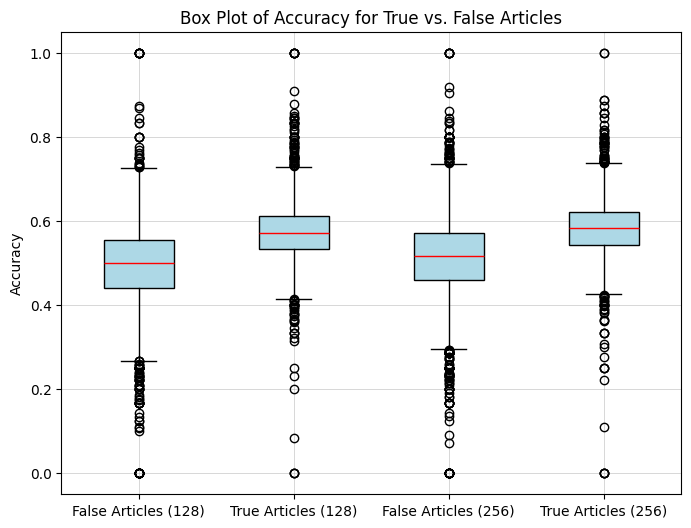

In [ ]:
# Combine into a list for plotting
data = [
    df_label_0_128["accuracy"],
    df_label_1_128["accuracy"],
    df_label_0_256["accuracy"],
    df_label_1_256["accuracy"],
]
labels = [
    "False Articles (128)",
    "True Articles (128)",
    "False Articles (256)",
    "True Articles (256)",
]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),  # Color for boxes
    medianprops=dict(color="red"),
)  # Color for median lines

plt.grid(True, linewidth=0.5, alpha=0.7)

# Add title and labels
plt.title("Box Plot of Accuracy for True vs. False Articles")
plt.ylabel("Accuracy")

# Show the plot
plt.savefig("boxplot_accuracy.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

In [ ]:
def calculate_outliers(data):
    # Calculate Q1, Q3, and IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(lower_bound)
    print(upper_bound)
    # Identify outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers


# Calculate outliers for each class
true_articles_outliers = calculate_outliers(df_label_1_128["accuracy"])
false_articles_outliers = calculate_outliers(df_label_0_128["accuracy"])

# Print the number of outliers
print(f"Number of outliers in True Articles: {len(true_articles_outliers)}")
print(f"Number of outliers in False Articles: {len(false_articles_outliers)}")

0.4143430402233219
0.7316504885166857
0.2672955974842767
0.728511530398323
Number of outliers in True Articles: 98
Number of outliers in False Articles: 108


In [ ]:
# Calculate outliers for each class
true_articles_outliers = calculate_outliers(df_label_1_256["accuracy"])
false_articles_outliers = calculate_outliers(df_label_0_256["accuracy"])

# Print the number of outliers
print(f"Number of outliers in True Articles: {len(true_articles_outliers)}")
print(f"Number of outliers in False Articles: {len(false_articles_outliers)}")

0.4249713749496427
0.738843638421895
0.29434957471243756
0.7376759694582518
Number of outliers in True Articles: 89
Number of outliers in False Articles: 146


In [48]:
df_accuracies = create_accuracy_dataframe(all_accuracies)

c:\Users\matej\SKOLA\Diplomovka\Code\EmbeddingModels\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\matej\SKOLA\Diplomovka\Code\EmbeddingModels\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [49]:
df_accuracies.describe()

,article_id,label,accuracy
count,5990.000000,5990.000000,5984.000000
mean,2994.500000,0.492821,0.547268
std,1729.308388,0.499990,0.097216
min,0.000000,0.000000,0.000000
25%,1497.250000,0.000000,0.500000
50%,2994.500000,0.000000,0.554110
75%,4491.750000,1.000000,0.603448
max,5989.000000,1.000000,1.000000


In [50]:
df_accuracies = df_accuracies.dropna()

In [51]:
df_label_0 = df_accuracies[df_accuracies["label"] == 0]
df_label_1 = df_accuracies[df_accuracies["label"] == 1]

In [52]:
df_label_0 = df_label_0.reset_index()
df_label_1 = df_label_1.reset_index()

In [53]:
df_label_0.describe()

,index,article_id,label,accuracy
count,3036.000000,3036.000000,3036.0,3036.000000
mean,2989.642292,2989.642292,0.0,0.512914
std,1746.913551,1746.913551,0.0,0.106146
min,0.000000,0.000000,0.0,0.000000
25%,1473.750000,1473.750000,0.0,0.460597
50%,2956.000000,2956.000000,0.0,0.516627
75%,4524.750000,4524.750000,0.0,0.571429
max,5987.000000,5987.000000,0.0,1.000000


In [54]:
df_label_1.describe()

,index,article_id,label,accuracy
count,2948.000000,2948.000000,2948.0,2948.000000
mean,3000.036974,3000.036974,1.0,0.582648
std,1711.092932,1711.092932,0.0,0.071525
min,2.000000,2.000000,1.0,0.000000
25%,1532.500000,1532.500000,1.0,0.542673
50%,3030.000000,3030.000000,1.0,0.582934
75%,4464.500000,4464.500000,1.0,0.621142
max,5989.000000,5989.000000,1.0,1.000000


In [55]:
df_accuracies

,article_id,label,accuracy
0,0,0,0.570248
1,1,0,0.500000
2,2,1,0.650000
3,3,0,0.583333
4,4,1,0.675325
...,...,...,...
5985,5985,1,0.615385
5986,5986,0,0.495671
5987,5987,0,0.521053
5988,5988,1,0.626866


In [56]:
from sklearn.metrics import accuracy_score

# Define the range of thresholds
min_threshold = df_accuracies["accuracy"].min()
max_threshold = df_accuracies["accuracy"].max()
thresholds = np.linspace(min_threshold, max_threshold, 1000)

# Initialize variables to track the best threshold and score
best_threshold = None
best_score = -1
best_predictions = None  # Variable to store predictions for the best threshold

# Iterate over thresholds
for threshold in thresholds:
    # Apply threshold to create predictions
    predictions = (df_accuracies["accuracy"] >= threshold).astype(int)

    # Calculate accuracy
    score = accuracy_score(df_accuracies["label"], predictions)

    # Update best threshold and score if this is the best so far
    if score > best_score:
        best_score = score
        best_threshold = threshold
        best_predictions = predictions  # Save the predictions for the best threshold

print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy: {best_score}")

Best Threshold: 0.5375375375375375
Best Accuracy: 0.6903409090909091


In [57]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

class_report = classification_report(df_accuracies["label"], best_predictions)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(df_accuracies["label"], best_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.60      0.66      3036
           1       0.66      0.78      0.71      2948

    accuracy                           0.69      5984
   macro avg       0.70      0.69      0.69      5984
weighted avg       0.70      0.69      0.69      5984

Confusion Matrix:
[[1835 1201]
 [ 652 2296]]


In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Replace these with your actual data
y_true = df_accuracies["label"]
y_pred = best_predictions

# Compute metrics
precision = precision_score(y_true, y_pred)  # or 'macro' if you prefer
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.6566
Recall: 0.7788
F1-Score: 0.7125
Accuracy: 0.6903


In [59]:
df_accuracies["label"].value_counts()

label
0    3036
1    2948
Name: count, dtype: int64